# Install libs

In [1]:
#!pip install --user nbmultitask
#!pip install pandas==1.2.5
#!pip install tqdm==4.61.1

# Imports

In [2]:
import sys
import zipfile
import os
from random import sample 


import numpy as np
import pandas as pd
from IPython.display import display, HTML
import seaborn as sns
from matplotlib import ticker

from lib.datasetutil import gerar_estatiscas_df, substituir_valores_nulos , verify_gg4cc , save_zip2


import numpy as np
import multiprocessing as mp
import pandas as pd

# from tqdm import tqdm
# from tqdm.notebook import trange, tqdm
from tqdm.notebook import tqdm

from splitting_bf.evaluation import split_bf
import multiprocessing as mp
from lib.util.env import getbase_dir
from encrypt import encryptData, encrypt_data_in_memory
import resposta


# Questão 1

## Metodos

In [3]:
def read(zinput):
    '''
        Ler zip com os datasets
    '''
    zf = zipfile.ZipFile(zinput) 

    scol = [68,2,10,11,9,28,29,13,14,15,1,16]

    df = pd.read_csv(zf.open(zipfile.ZipFile.namelist(zf)[0]),header=0,
                encoding="iso-8859-1",sep="\t",
                usecols=scol,
    #             chunksize=640000000,
                error_bad_lines=False)#,
#             nrows=15)
    return df.iloc[:, [11,1,3,4,2,9,10,5,6,0,7,8,]]

# df.iloc[:, [68,2,10,11,9,28,29,13,14,15,1,16]]

## Leitura dos dados

In [4]:
ds_files = 'D:\Dados\OneDrive\Doutorado\Datasets\\NCVR\\'
fa = 'ncvoter_Statewide_18102016.zip'
fb = 'ncvoter_Statewide_31052020.zip'

In [13]:
#[1,2,3,4,5,6,7] ,96,cores=8
a = read(ds_files + fa)

In [ ]:
#[7,8,9,10,11,12,13],96,cores=8
# b = read(ds_files + fb)

In [ ]:
# del(b)

## Simular

Bootstrap

In [15]:
%%time
# 5 ~ 8
# 6 ~ 16

# nova execucao 7,11
# for i in range(8,11):
for i in tqdm(range(2,8),leave=True):
    n_proc = 4
    pool = mp.Pool(processes=n_proc)
    results = [pool.apply_async(
                                resposta.first_question,
                                args=(s,[1,2,3,4,5,6,7],96),
                                kwds={'sample_size': 0,
                                      'n_splits':i,
                                      'limite':4}
                                ) for s in np.array_split(a.sample(10000), n_proc)
#                                 ) for s in np.array_split(a.sample(1000000), n_proc)
#                                 ) for s in np.array_split(a.sample(4000000), n_proc)
              ]

    output = [p.get() for p in results]
    pool.close()

    output = pd.concat(output).groupby(['split']).sum()
    output['split'] = output.index
    output['n_split'] = 2**i
    output.to_csv('computacao_10k_'+str(i)+'.csv')

  0%|          | 0/6 [00:00<?, ?it/s]

Wall time: 1min 10s


## Gerar os Graficos

In [5]:
output = []
sample_s = {'10k' : 10000, '100k' : 100000, '1mi' : 1000000}
for l in tqdm(['10k','100k','1mi'],leave=False):
    for i in tqdm(range(2,8),leave=False):
        j = pd.read_csv('computacao_'+str(l)+'_'+str(i)+'.csv')
        j['sample_size'] = sample_s[l]
        if len(output) == 0:
            output = j
        else:
            output = pd.concat([output,j])

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [6]:
output['bits'] = 1024/output['n_split']
output['n_split'] = output['n_split'].astype(int)
output['punique'] = output['unique']/output['sample_size']
# output

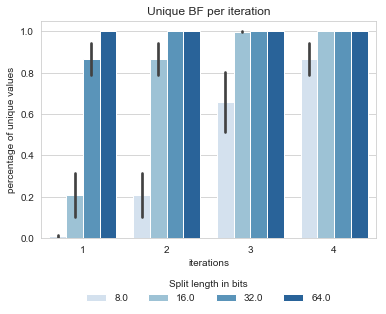

In [8]:
z=output[output['sample_size'] >= 10000]
sns.set_style("whitegrid")
g = sns.barplot(data=z[z.bits <= 64], x="split",y='punique',hue='bits',palette='Blues')
g.set_title('Unique BF per iteration')
g.set_xlabel('iterations')
g.set_ylabel('percentage of unique values')
g.legend(loc='upper center', bbox_to_anchor=(.5, -.15),
                      title= 'Split length in bits',
                      fancybox=True, frameon=False , ncol=4)

# Questao 2

Ola

## metodos

In [ ]:
def verificar_distancias(bdf,split_number=16,limiar = 0.7,alfa = 0.1):
#     bdf = df[df.bf == 'bbf']
    
    beta = limiar - alfa
    distancia = 0

    saida = []
    #
    for a in bdf['id_a'].unique():

        distanciais_locais = []
        
        for row in bdf[bdf.id_a == a].iterrows():
            #procura a disntancia de a
            for i in range(4,split_number+4):
                #ta errado se tiver uma no meio tem que parar
                if row[1][i] >= beta:
                    distancia = i - 3
                else:
                    #nao repassa a split
                    break

                distanciais_locais.append(distancia)

        if len(distanciais_locais) == 0:
            dist = 1
        else:
            dist = max(distanciais_locais)
            
        saida.append({'id_a' : a, 'distancia' : dist})

    return pd.DataFrame(saida)

In [ ]:
from resposta import local_encrypt
from lib.mybloom.bloomutil import jaccard_coefficient

def comparar_second_question_rt(df1,df2,atts,bfsize,n_splits=6,limiar = 0.7,alfa = 0.1):
    edf1=local_encrypt(df1,atts,bfsize,sample_size=0)
    edf2=local_encrypt(df2,atts,bfsize,sample_size=0)
    
    beta = limiar - alfa
    distancia = 0

    saida = []
    
    for e1 in tqdm(edf1,leave=False):
        
        id1 = e1[0]
        bf1 = e1[1]
        
        distanciais_locais = []
        for e2 in tqdm(edf2,leave=False):
            id2 = e2[0]
            bf2 = e2[1]
            
            #BBF parts
            bbf1_parts = split_bf(bf1,n_splits)
            bbf2_parts = split_bf(bf2,n_splits)
            
            #######
            ## processando
            #######
            for i in range(0,len(bbf1_parts)):

#                 jaccard_coefficient(ibf1_parts[i], ibf2_parts[i])
#                 jaccard_coefficient(xbf1_parts[i], xbf2_parts[i])
                if jaccard_coefficient(bbf1_parts[i], bbf2_parts[i]) >= beta:
                    distancia = i+1
                else:
                    #nao repassa a split
                    break

                distanciais_locais.append(distancia)
             #############################################
        
        #fim do for 2
        if len(distanciais_locais) == 0:
            dist = 1
        else:
            dist = max(distanciais_locais)
            
        saida.append({'id_a' : id1, 'distancia' : dist})
                
    return pd.DataFrame(saida)

## ler os dados

In [30]:
ds_files = '..\..\..\..\Datasets\\NCVR\\'
fa = 'ncvoters_5000_0.1.zip'

zinput = ds_files + fa

#ler os dados para comparacao

zf = zipfile.ZipFile(zinput)

df = pd.read_csv(zf.open(zipfile.ZipFile.namelist(zf)[0]),header=0,
                 encoding="iso-8859-1",sep=";",
#                 usecols=scol,
    #             chunksize=640000000,
                error_bad_lines=False)#,
a = df.iloc[:, [0,3,4,2,5,6,7,8]]

df = pd.read_csv(zf.open(zipfile.ZipFile.namelist(zf)[1]),header=0,
                 encoding="iso-8859-1",sep=";",
#                 usecols=scol,
    #             chunksize=640000000,
                error_bad_lines=False)#,
b = df.iloc[:, [0,3,4,2,5,6,7,8]]

In [31]:
# blocando
ba = a.copy()
bb = b.copy()

# aumentar
ba['bk'] = ba.first_name.str[:2]
bb['bk'] = bb.first_name.str[:2]


comps = pd.merge(ba, bb, on=["bk"])[['ncid_x','ncid_y']]
comps.columns = ['a','b']

len(comps.a.unique())

1660

calcular similaridades

In [32]:
from resposta import local_encrypt
from splitting_bf.evaluation import split_bf
from lib.mybloom.bloomutil import jaccard_coefficient
from statistics import mean


def comparar_second_question_rt_blk(df1,df2,comps,excluidos_a,atts,bfsize,n_splits=6,limiar = 0.7,alfa = 0.1):
    edf1=local_encrypt(df1,atts,bfsize,sample_size=0)
    edf2=local_encrypt(df2,atts,bfsize,sample_size=0)
    
    beta = limiar - alfa
    distancia = 0

    saida = []
    
    
#     for e1 in edf1:
    for e1 in tqdm(edf1,leave=False):
        id1 = e1[0]
        bf1 = e1[1]
        
        distanciais_locais = []
        
        try:
            excluidos_a[id1]
            distanciais_locais.append(-1)
        except KeyError:
        
            for e2 in edf2:
                id2 = e2[0]
                bf2 = e2[1]

                flag = False
                try:
                    pass
                    # flag = comps[(comps.a == id1) & (comps.b == id2)]
                    c[str(id1)+str(id2)]
                    flag = True
                except KeyError:
                    flag = False


                if flag == True:
                    #BBF parts
                    bbf1_parts = split_bf(bf1,n_splits)
                    bbf2_parts = split_bf(bf2,n_splits)

                    #######
                    ## processando
                    #######
                    
                    llimiar = [limiar]
                    for i in range(0,len(bbf1_parts)):
                        beta = mean(llimiar) - alfa

                        parts = jaccard_coefficient(bbf1_parts[i], bbf2_parts[i])
        #                 jaccard_coefficient(ibf1_parts[i], ibf2_parts[i])
        #                 jaccard_coefficient(xbf1_parts[i], xbf2_parts[i])

                        if parts >= beta:
                            llimiar.append(parts)
                            distancia = i + 1
                        else:
                            #nao repassa a split
                            break

                        distanciais_locais.append(distancia)
                     #############################################
        
        
        #fim do for 2
        if len(distanciais_locais) == 0:
            dist = 1
        else:
            dist = max(distanciais_locais)
            
        saida.append({'id_a' : id1, 'distancia' : dist})
                
    return pd.DataFrame(saida)

In [33]:
# c = {}
# for index, row in comps.iterrows():
#     c[str(row[0])+str(row[1])] = 1

In [35]:
excluidos_a = dict.fromkeys(set(a.ncid) - set(comps.a.unique()), 1)
bb = b[~b.ncid.isin( list(set(b.ncid) - set(comps.b.unique())) ) ]

In [36]:
len(set(a.ncid.unique()).intersection(set(b.ncid.unique())))

170

### Simular

In [131]:
# simular e executar
zd = comparar_second_question_rt_blk(a,bb,c,excluidos_a,[2,3,4,5,6,7],96,n_splits=5,limiar = 0.7,alfa = 0.3)

### Gerar graficos

In [147]:
z = zd.copy()
z['label'] = 'filtered with less 25%'
z.loc[z.distancia == -1, 'label'] = 'filtered by blocking'
z.loc[z.distancia >= 9, 'label'] = 'forwarded with more than 25%'
z.distancia=z.distancia.replace({-1: 1})

Text(0.5, 0, 'iterations')

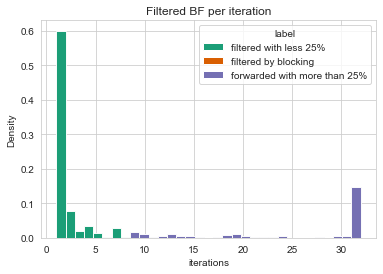

In [148]:
sns.set_style("whitegrid")
g = sns.histplot(z[z.distancia > 0],x='distancia',stat='density',bins=33,hue='label',
                 palette='Dark2',
                 alpha=1.0
                )
g.set_title('Filtered BF per iteration')
g.set_xlabel('iterations')